In [4]:
import sys, os, time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rasterio
import rasterio.mask
import rasterio.io
import rasterio.errors
import fiona
import fiona.transform
import shapely
import shapely.geometry

import collections

In [5]:
NLCD_CLASS_VALS = [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95]
NLCD_CLASS_NAMES = [
    "Open Water",
    "Perennial Ice/Snow",
    "Developed, Open Space",
    "Developed, Low Intensity",
    "Developed, Medium Intensity",
    "Developed High Intensity",
    "Barren Land (Rock/Sand/Clay)",
    "Deciduous Forest",
    "Evergreen Forest",
    "Mixed Forest",
    "Shrub/Scrub",
    "Grassland/Herbaceous",
    "Pasture/Hay",
    "Cultivated Crops",
    "Woody Wetlands",
    "Emergent Herbaceous Wetlands"
]

In [6]:
columns = """A00001_001|Total Population
A03001_001|Total Population:
A03001_002|Total Population: White Alone
A03001_003|Total Population: Black or African American Alone
A03001_004|Total Population: American Indian and Alaska Native Alone
A03001_005|Total Population: Asian Alone
A03001_006|Total Population: Native Hawaiian and Other Pacific Islander Alone
A03001_007|Total Population: Some Other Race Alone
A03001_008|Total Population: Two or More Races
A12001_001|Population 25 Years and Over:
A12001_002|Population 25 Years and Over: Less than High School
A12001_003|Population 25 Years and Over: High School Graduate (Includes Equivalency)
A12001_004|Population 25 Years and Over: Some College
A12001_005|Population 25 Years and Over: Bachelor's Degree
A12001_006|Population 25 Years and Over: Master's Degree
A12001_007|Population 25 Years and Over: Professional School Degree
A12001_008|Population 25 Years and Over: Doctorate Degree
A14006_001|Median Household Income (In 2016 Inflation Adjusted Dollars) [Dollars adjusted for inflation to match value in 2016]
A14028_001|Gini Index
A10044_001|Housing Units:
A10044_002|Housing Units: Occupied
A10044_003|Housing Units: Vacant
A10062B_001|Total Population in Occupied Housing Units: Renter Occupied
A10062B_002|Total Population in Occupied Housing Units: Renter Occupied: 1, Detached or Attached
A10062B_003|Total Population in Occupied Housing Units: Renter Occupied: 2 to 4
A10062B_004|Total Population in Occupied Housing Units: Renter Occupied: 5 or More
A10062B_005|Total Population in Occupied Housing Units: Renter Occupied: Mobile Home
A10062B_006|Total Population in Occupied Housing Units: Renter Occupied: Boat, Rv, Van, Etc.
A09003_001|Average Commute to Work (in Min)
"""
column_map = {}
for line in columns.strip().split("\n"):
    header, description = line.split("|")
    column_map["SE_" + header] = description

## Example

In [19]:
df = pd.read_csv("data/processed/acs5yr/acs_5yr_2016_nlcd_joined_data.csv", sep="\t", encoding="ISO-8859-1", dtype={
    "Geo_FIPS":str,
    "Geo_STATE":str,
    "Geo_COUNTY":str
})
df["Geo_StateCounty"] = df["Geo_STATE"]+df["Geo_COUNTY"]
df.set_index("Geo_FIPS", inplace=True)

for column in column_map: # sanity checks
    assert column in df.columns
    
nlcd_count_columns = []
for column in df.columns:
    if column.startswith("nlcd-"):
        nlcd_count_columns.append(column)
        
df["nlcd-total"] = df.loc[:,nlcd_count_columns].sum(axis=1) # sum the nlcd counts

In [20]:
# We use the Census rural-urban codes here. This data source scores each county from 1-7 to each county based on how rural it is
# See the data descriptions in `data/ruralurbancodes2013.xls`

rural_urban_codes = pd.read_csv("data/ruralurbancodes2013_simplified.csv", delimiter=",", encoding="ISO-8859-1", dtype={
    "FIPS":str
})
county_fips = rural_urban_codes["FIPS"].values
urban_county_fips = set(county_fips[rural_urban_codes["RUCC_2013"] == 1])
rural_county_fips = set(county_fips[rural_urban_codes["RUCC_2013"] > 7])

In [21]:
urban_census_tract_mask = df["Geo_StateCounty"].apply(lambda x: x in urban_county_fips)
rural_census_tract_mask = df["Geo_StateCounty"].apply(lambda x: x in rural_county_fips)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


38594


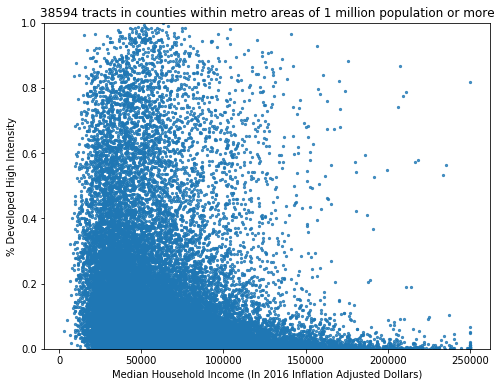

In [23]:
x = df["SE_A14006_001"].values
y = df["nlcd-developed_high_intensity"].values / df["nlcd-total"].values
mask = (~np.isnan(x)) & (~np.isnan(y)) & urban_census_tract_mask

print(mask.sum())

plt.figure(figsize=(8,6), facecolor="white")
plt.scatter(x[mask], y[mask], s=5, alpha=0.8)
plt.xlabel("Median Household Income (In 2016 Inflation Adjusted Dollars)")
plt.ylabel("% Developed High Intensity")
plt.ylim([0, 1])
plt.title("%d tracts in counties within metro areas of 1 million population or more" % (mask.sum()))
plt.show()
plt.close()